### Catboost1

In [29]:
import pandas as pd
import numpy as np
import catboost as cat

In [2]:
print(catboost.__version__)

1.0.3


In [14]:
# globals
FIGSIZE = (9, 6)

SEED = 42

FILE_TRAIN = "train.csv"

In [15]:
#
# my split in train, test set
#
def my_train_test_split(df, frac):
    # frac: the fraction used for train
    # df: the dataframe
    
    # shuffle before split
    df = df.sample(frac=1., random_state=SEED)

    # FRAC = 0.90
    tot_rec = df.shape[0]
    NUM_TRAIN = int(frac*tot_rec)
    NUM_TEST = tot_rec - NUM_TRAIN

    data_train = df[:NUM_TRAIN]
    data_test = df[NUM_TRAIN:]

    print()
    print('Numero totale di campioni:', tot_rec)
    print('Numero di campioni nel TRAIN SET:', data_train.shape[0])
    print('Numero di campioni nel TEST SET:', data_test.shape[0])
    
    return data_train, data_test

In [16]:
data_orig = pd.read_csv(FILE_TRAIN)

In [23]:
all_columns = data_orig.columns

# colonne da ignorare
del_columns = ['datetime', 'casual', 'registered']

TARGET = "count"

cat_cols = ['season', 'holiday','workingday', 'weather']

num_cols = list(set(all_columns) - set([TARGET]) - set(del_columns) - set(cat_cols))

features = sorted(cat_cols + num_cols)

print('Tutte le colonne:', len(all_columns))
print('Colonne ignorate:', len(del_columns))
print('target:', len([TARGET]))
print('Colonne cat:', len(cat_cols))
print('Colonne num:', len(num_cols))

Tutte le colonne: 12
Colonne ignorate: 3
target: 1
Colonne cat: 4
Colonne num: 4


In [24]:
data_used = data_orig.drop(del_columns, axis=1)

In [25]:
FRAC = 0.90

data_train, data_test = my_train_test_split(data_used, frac=FRAC)


Numero totale di campioni: 10886
Numero di campioni nel TRAIN SET: 9797
Numero di campioni nel TEST SET: 1089


In [28]:
# separo X ed y
x_train = data_train[features]
y_train = data_train[TARGET]

x_test = data_test[features]
y_test = data_test[TARGET]

# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(x_train.columns) if col in cat_cols]

In [38]:
%%time
# First: try without addressing data imbalance

params = {'iterations':5000,
          'learning_rate':0.005,
          'depth':10,
          'task_type':"GPU"
         }

model = cat.CatBoostRegressor(**params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=500, early_stopping_rounds=50, eval_set=(x_test, y_test))

0:	learn: 181.2785594	test: 177.2255208	best: 177.2255208 (0)	total: 79.8ms	remaining: 6m 38s
500:	learn: 145.3967621	test: 147.3651038	best: 147.3651038 (500)	total: 30.7s	remaining: 4m 35s
1000:	learn: 142.1507150	test: 145.6174908	best: 145.6166899 (998)	total: 1m	remaining: 4m 1s
1500:	learn: 140.6573639	test: 144.9632169	best: 144.9632169 (1500)	total: 1m 30s	remaining: 3m 30s
2000:	learn: 139.6254603	test: 144.5657187	best: 144.5654900 (1999)	total: 1m 58s	remaining: 2m 57s
2500:	learn: 138.8805710	test: 144.3079110	best: 144.3079110 (2500)	total: 2m 28s	remaining: 2m 28s
3000:	learn: 138.3326838	test: 144.1296414	best: 144.1290234 (2996)	total: 3m 1s	remaining: 2m
3500:	learn: 137.9158833	test: 144.0259006	best: 144.0259006 (3500)	total: 3m 32s	remaining: 1m 31s
4000:	learn: 137.5419615	test: 143.9360000	best: 143.9356491 (3999)	total: 4m 3s	remaining: 1m
4500:	learn: 137.2085849	test: 143.8314619	best: 143.8314619 (4500)	total: 4m 33s	remaining: 30.4s
4999:	learn: 136.9341973	t

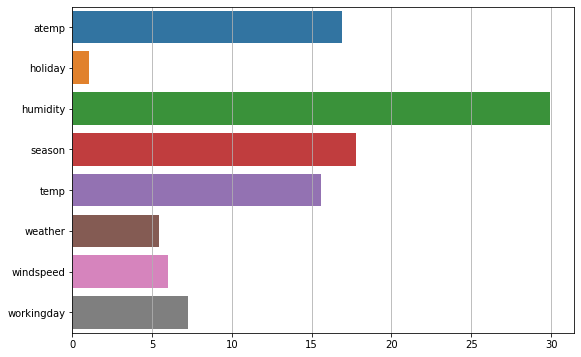

In [43]:
%matplotlib inline

# eXplainability: Feature importance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = FIGSIZE)
plt.grid(True)
sns.barplot(x = model.get_feature_importance(), y = features);

### Submission

In [66]:
test_orig = pd.read_csv("test.csv")

In [67]:
v_test = test_orig[features]

In [68]:
score_test = model.predict(v_test)

In [69]:
score_test.shape

(6493,)

In [70]:
df_sub = pd.read_csv("sampleSubmission.csv")

In [71]:
df_sub["count"] = score_test

In [73]:
condition = df_sub["count"] < 0

df_sub.loc[condition, "count"] = 0

In [74]:
df_sub.describe()

,count
count,6493.000000
mean,186.764388
std,106.194326
min,0.000000
25%,101.310298
50%,161.839960
75%,258.927484
max,554.101380


In [75]:
FILE_SUB = "submission1.csv"

df_sub.to_csv(FILE_SUB, index=False)

In [76]:
!kaggle competitions submit -c "bike-sharing-demand" -f $FILE_SUB -m "sub1"

100%|█████████████████████████████████████████| 244k/244k [00:01<00:00, 193kB/s]
Successfully submitted to Bike Sharing Demand